# 1.  Import needed libraries

In [2]:
from emissivity import Emissivity

In [3]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import rasterio

In [4]:
import numpy as np

# 2. Load image from Esprito Santo in Brazil

In [5]:
file_path = './data/espirito_santo/LC08_L1TP_216074_20160531_20180528_01_T1_B10.TIF'

In [6]:
def read_image(file_path, band_num):
    """
    
    Arguments
    
    file_path (str): local path to single or multiband image 
    band_num (int): index of image band to load (starting from one)
    """
    
    assert band_num > 0, "Band index should start counting from 1"
        
    data = rasterio.open(file_path)
    return data.read(band_num).astype(float)

// TO DO

- Change preprocessLandsat class LandsatBrightnessTemp()
- Create a class named compute mask that takes in the raw image and outputs the mask
- Create Split window classes 
- Create a a wrapper module that computes the land surface temperature using the wrapper
- Sample packages for documentation 
        - https://pypi.org/project/tsmoothie/

In [7]:
img = read_image(file_path, 1)

In [8]:
def generate_mask(image, mask_zeros=False)-> np.ndarray:
    """
    Return a bool array masking 0 and NaN values as False and others as True

    Args:
        image (np.ndarray): Single-band image
    """

    
    nan_mask = image == np.nan
    if mask_zeros:
        zero_mask = image == 0 
        mask_true = np.logical_and(zero_mask, nan_mask)
    else:
        mask_true = nan_mask

    return mask_true

In [9]:
mask = generate_mask(img)

In [10]:
img[mask] = np.nan

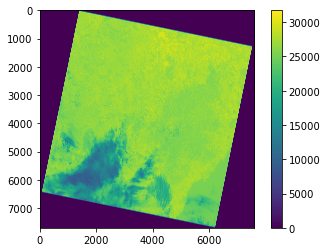

In [11]:
plt.imshow(img)
plt.colorbar()

In [12]:
import numpy.ma as ma

masked_img = ma.masked_less_equal(img, 0)

In [13]:
masked_img.set_fill_value = 9

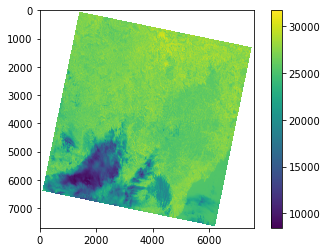

In [14]:
plt.imshow(masked_img)
plt.colorbar()

# 3. Digital number to Brightness temperature

In [14]:
from preprocess import PreprocessLandsat

ModuleNotFoundError: No module named 'utils'

#### Coeffients as obtained from meta-data. This is used as arguments for the preprocessor 

In [ ]:
mult_factor = 3.3420E-04
add_factor = 0.10000
k1_constant = 774.8853
k2_constant = 1321.0789

##### initialize the preprocessor 

In [20]:
preprocessor = PreprocessLandsat(mult_factor, add_factor, k1_constant, k2_constant)

In [21]:
brightness_temp_image = preprocessor(img)

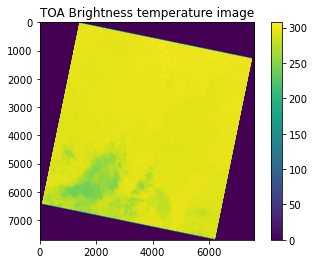

In [23]:
plt.imshow(brightness_temp_image)
plt.colorbar()
plt.title('TOA Brightness temperature image')
plt.show()

# 4. Emmisivity computation
Emmisivity can be obtained from NDVI image. The NDVI is computed from the Red and Near-infrared (NIR) band images

#### Load Red and NIR data

In [15]:
red_path = './data/espirito_santo/LC08_L1TP_216074_20160531_20180528_01_T1_B4.TIF'
nir_path = './data/espirito_santo/LC08_L1TP_216074_20160531_20180528_01_T1_B5.TIF'

In [16]:
red_band = rasterio.open(red_path).read(1)
nir_band = rasterio.open(nir_path).read(1)

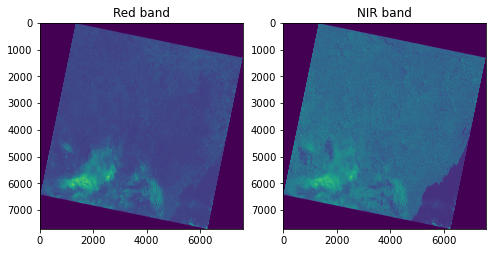

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.imshow(red_band)
ax1.set_title('Red band')
ax2.imshow(nir_band)
ax2.set_title('NIR band')
#plt.colorbar()
plt.show()

In [18]:
def generate_mask(image)-> np.ndarray:
    """
    Return a bool array masking 0 and NaN values as False and others as True

    Args:
        image (np.ndarray): Single-band image
    """

    zero_mask = image != 0 #or image != np.nan
    nan_mask = image != np.nan
    mask_true = np.logical_and(zero_mask, nan_mask)

    return mask_true


In [19]:
def compute_ndvi(nir, red, eps=1e-15):
    
    assert nir.shape == red.shape, f"Both images must be of the same dimaension, {nir.shape}, {red.shape}"
    
    
    ndvi = np.empty(nir.shape)
    mask_nir = generate_mask(nir_band)
    mask_red = generate_mask(red_band)
    mask = np.logical_and(mask_nir, mask_red)


    
    ndvi = (nir - red) / (nir + red + eps)
    
    to_return = np.where(np.abs(ndvi)>1,np.nan, ndvi) 
    
    i, j = np.where(~mask)
    to_return[i, j] = np.nan
    return to_return

In [20]:
ndvi_image = compute_ndvi(nir_band, red_band)

In [21]:
emm = Emissivity(ndvi_image)

In [22]:
print(emm)

In [23]:
mask = emm._get_land_surface_mask()

AttributeError: 'Emissivity' object has no attribute '_get_land_surface_mask'

In [23]:
np.isnan(ndvi_image)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [24]:
ndvi_image != np.nan

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

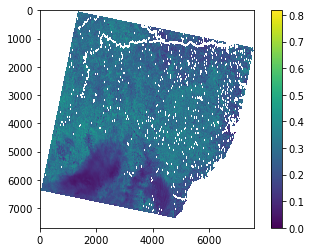

In [25]:
plt.imshow(ndvi_image)
plt.colorbar()

In [26]:
#Method 1 (RECOMMENDED for mono-window technique)
def mono_window_emmissivity(ndvi):
    emissivity = np.empty(ndvi.shape)
    # Reference:
    nan_mask = np.isnan(ndvi_image)
    
    # Set values in emissivity matrix based on NDVI matrix value with same index
    mask1 = (ndvi >= -1) & (ndvi < 0.2)
    mask2 = (ndvi > 0.5) & (ndvi <= 1)
    mask3 = (ndvi >= 0.2) & (ndvi <= 0.5)
    

    i, j = np.where(mask1)
    emissivity[i, j] = 0.97
    i, j =np.where(mask2)
    emissivity[i, j] = 0.99
    i, j = np.where(mask3)
    emissivity[i, j] = (0.004*(((ndvi[i, j] - 0.2)/(0.5 - 0.2))**2)) + 0.986
    i, j = np.where(nan_mask)
    emissivity[i, j] = np.nan
    return emissivity

In [27]:
emm = mono_window_emmissivity(ndvi_image)

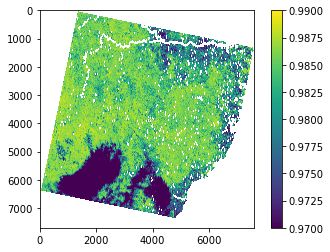

In [28]:
plt.imshow(emm)
plt.colorbar()

In [29]:
mask_veg = ndvi_image > 0.1

In [30]:
i, j = np.where(~mask_veg)

In [31]:
veg_map = np.copy(ndvi_image)
veg_map[i,j] = np.nan
np.unique(veg_map).shape

(40983608,)

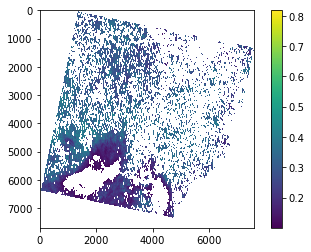

In [32]:
plt.imshow(veg_map)
plt.colorbar()